<a href="https://colab.research.google.com/github/tomrzonta/Portfolio-Departamento-Medico/blob/main/Departamento_M%C3%A9dico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Departamento médico

## Importação das bibliotecas e base de dados

In [1]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
xray_directory = '/content/drive/MyDrive/Departamento médico/Dataset'

In [5]:
os.listdir(xray_directory)

['.DS_Store', '0', '1', '2', '3']

In [6]:
image_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 530 images belonging to 4 classes.


In [8]:
133 * 4

532

In [9]:
532 / 40

13.3

In [10]:
train_images, train_labels = next(train_generator)

In [11]:
train_images.shape

(40, 256, 256, 3)

In [12]:
train_labels

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]],

In [13]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

## Visualização dos dados

In [14]:
np.arange(0, 36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [15]:
np.argmax(train_labels[0])

2

In [16]:
labels_names[1]

'Normal'

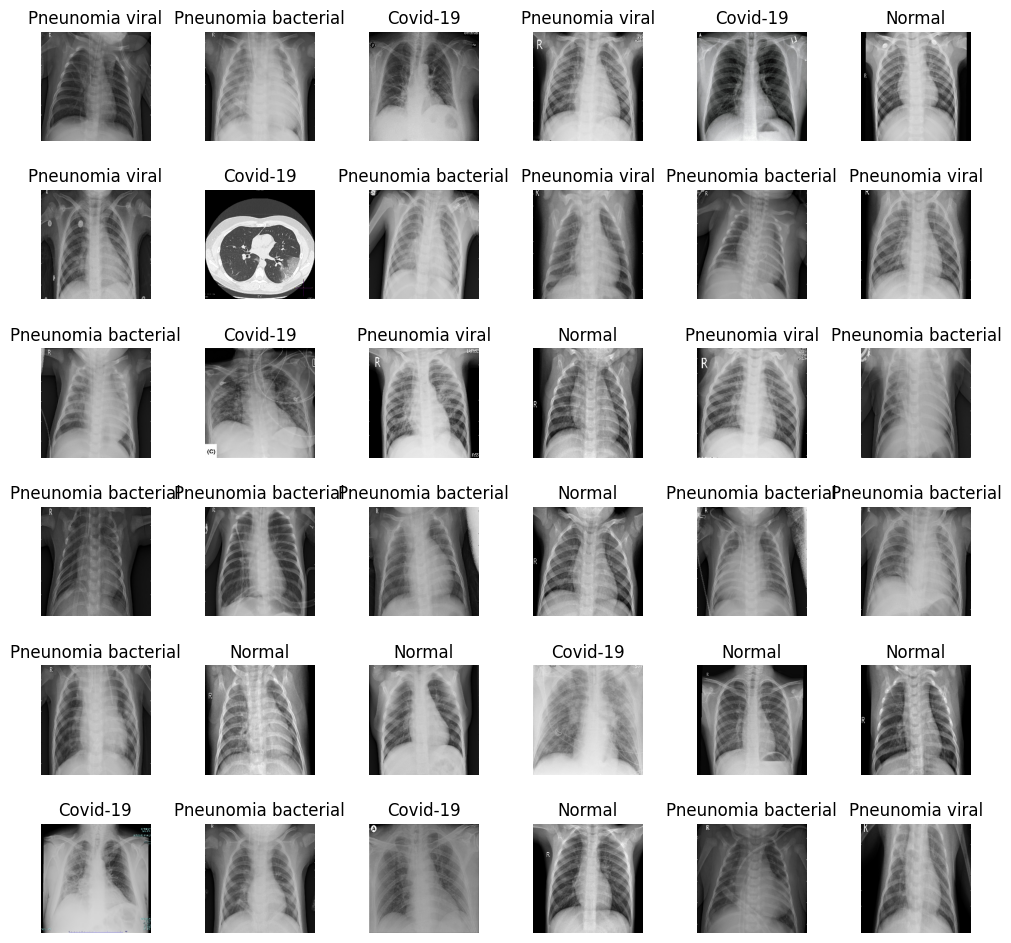

In [17]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Carregamento da rede neural com pesos pré-treinados

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 0s 0us/step


In [19]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [20]:
len(base_model.layers)

175

In [21]:
for layer in base_model.layers[:-10]:
  layers.trainable = False

## Construção e treinamento do modelo de deep learning

In [22]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [ ]:
model = Model(inputs = base_model.input, outputs = head_model)

In [ ]:
#model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              #metrics = ['accuracy'])

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = ['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, epochs = 25,
                              callbacks=[checkpointer])

<ipython-input-27-57e0cc005262>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs = 25,


Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 3.1468 - accuracy: 0.4267

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 166s 1s/step - loss: 3.1468 - accuracy: 0.4267
Epoch 2/25
133/133 [==============================] - 14s 103ms/step - loss: 1.3855 - accuracy: 0.4925
Epoch 3/25
133/133 [==============================] - 14s 103ms/step - loss: 1.1846 - accuracy: 0.6090
Epoch 4/25
133/133 [==============================] - 14s 106ms/step - loss: 0.9532 - accuracy: 0.6617
Epoch 5/25
133/133 [==============================] - 13s 95ms/step - loss: 0.8992 - accuracy: 0.6880
Epoch 6/25
133/133 [==============================] - 14s 104ms/step - loss: 0.8929 - accuracy: 0.7011
Epoch 7/25
133/133 [==============================] - 14s 102ms/step - loss: 0.8016 - accuracy: 0.7049
Epoch 8/25
133/133 [==============================] - 14s 101ms/step - loss: 0.7176 - accuracy: 0.7707
Epoch 9/25
133/133 [==============================] - 16s 117ms/step - loss: 0.6175 - accuracy: 0.8045
Epoch 10/25
133/133 [==============================] - 13s 99ms/step - loss: 0.5581 - a

## Avaliação da rede neural

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

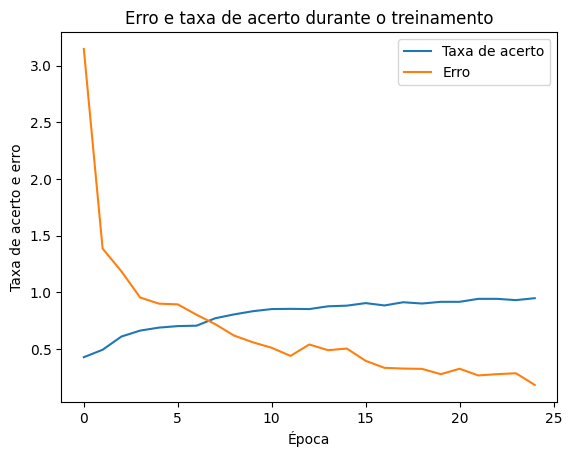

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [ ]:
test_directory = '/content/drive/My Drive/Cursos - recursos/Ciência de Dados da Empresas e Negócios/Departamento médico/Test'

In [ ]:
os.listdir(test_directory)

['0', '3', '2', '1']

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model.evaluate_generator(test_generator)

<ipython-input-33-fff1a6b05c9b>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator)


In [ ]:
evaluate

[1.934661865234375, 0.6000000238418579]

In [ ]:
len(os.listdir(test_directory))

4

In [ ]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 33ms/step


In [ ]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 1, 1, 1, 3, 0, 0, 0, 1, 2, 2, 2, 1, 0, 3, 2, 2, 2, 1, 3, 3, 3, 1, 2, 0, 3, 0, 0, 1]


In [ ]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
accuracy_score(original, prediction)

0.6

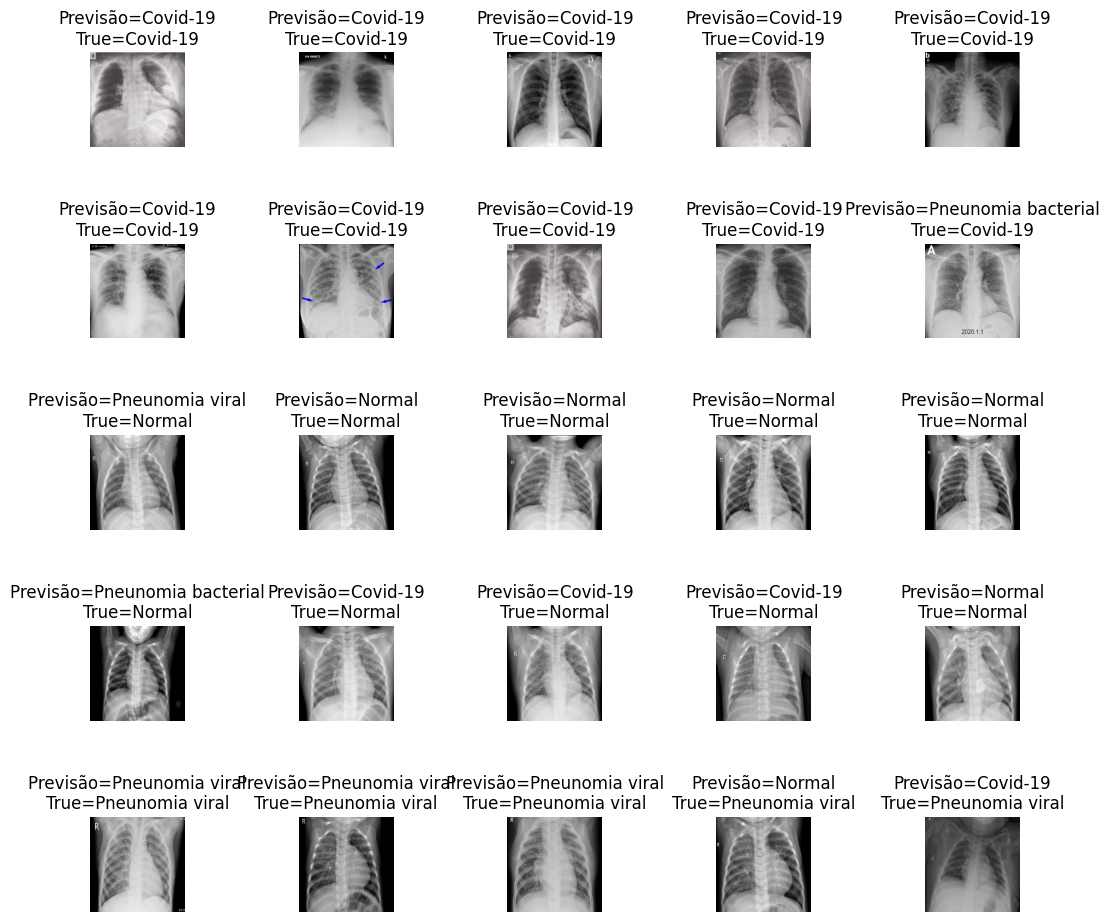

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

In [ ]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneunomia viral', 3: 'Pneunomia bacterial'}

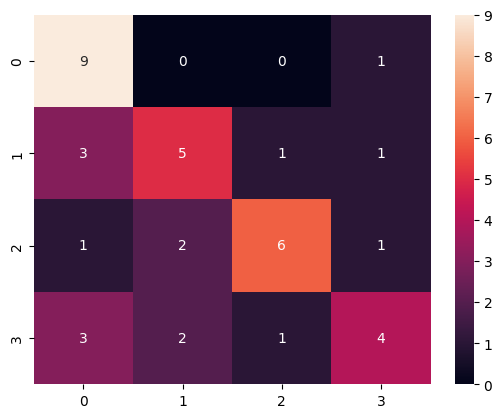

In [ ]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [ ]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.56      0.50      0.53        10
           2       0.75      0.60      0.67        10
           3       0.57      0.40      0.47        10

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.59        40
weighted avg       0.61      0.60      0.59        40



## Classificação de somente uma imagem

In [ ]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [ ]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
4 * 4 * 2048

32768

In [ ]:
img = cv2.imread('/content/drive/My Drive/Cursos - recursos/Ciência de Dados da Empresas e Negócios/Departamento médico/Test/0/radiol.2020200490.fig3.jpeg')

In [ ]:
img, img.shape

(array([[[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        ...,
 
        [[196, 196, 196],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  3,   3,   3],
         [134, 134, 134]],
 
        [[187, 187, 187],
         [  5,   5,   5],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  7,   7,   7],
         [129, 129, 129]],
 
        [[214, 214, 214],
         [ 80,  80,  80],
         [ 87,  87,  87],
         ...,
         [ 80,  80,  80],
  

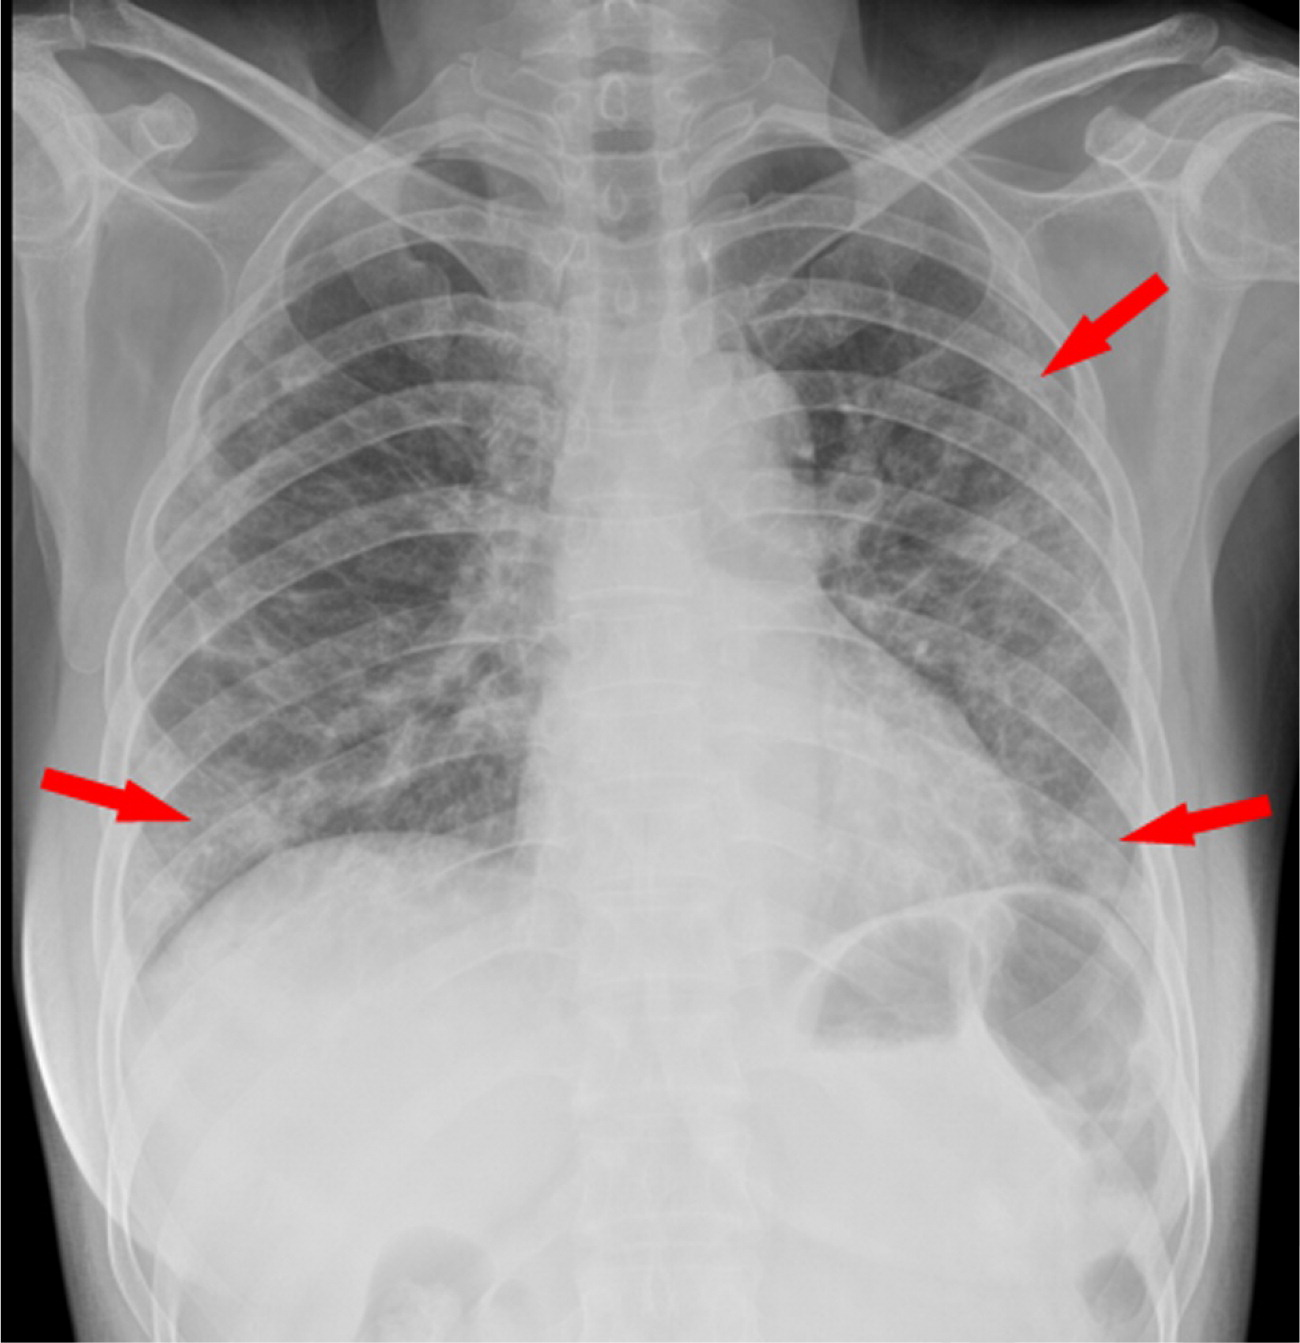

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

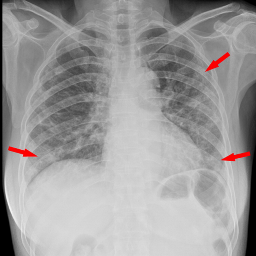

In [ ]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [ ]:
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [ ]:
img.shape

(256, 256, 3)

In [ ]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [ ]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[9.9999821e-01, 5.1909950e-07, 2.6138630e-07, 1.1034126e-06]],
      dtype=float32)>

In [ ]:
predict2 = np.argmax(predict)
predict2

0

In [ ]:
labels_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=0.9999982>)